Импорт библиотек для  дальнейшей работы.

In [553]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

Чтение файла, просмотр информации о хранящихся признаках. Вынес таблицу с данными в отдельный файл от задания.

In [554]:
with open('clean_data_AM.csv') as data:
    x = pd.read_csv(data, sep = ';')

In [555]:
df = pd.DataFrame(data = x, columns = x.columns)
df.fillna(0.0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   actionGroup            445 non-null    object 
 1   magazin                445 non-null    int64  
 2   days                   445 non-null    int64  
 3   Revenue                445 non-null    object 
 4   Checks                 445 non-null    int64  
 5   Qty                    445 non-null    int64  
 6   Avg Check Size         445 non-null    object 
 7   Avg Check              445 non-null    object 
 8   before days            445 non-null    float64
 9   before Revenue         445 non-null    object 
 10  before  Checks         445 non-null    float64
 11  before Qty             445 non-null    float64
 12  before Avg Check Size  445 non-null    object 
 13  before Avg Check       445 non-null    float64
dtypes: float64(4), int64(4), object(6)
memory usage: 48.8+ KB


Как можно видеть из представленной информации, в данном наборе данных требуется преобразовать типы данных из object в float. Также имеет смысл проверить первый столбец на уникальность, и в случае отсутствия иных значений кроме "Акция 1", его можно удалить.

In [556]:
L = len(df['Revenue'])
if len(list(df['actionGroup'].unique())) == 1:
        df.drop('actionGroup', axis = 1, inplace = True)
object_cols = df.loc[:, df.dtypes == 'O']

Далее в коде представлена обработка данных с целью изменения типа данных, а также разбиение на два массива: данные во время
акции, и данные без акции.

In [557]:
def DataConv(data, L, sep):
    PreparedData = np.ndarray((L))
    for i in range(L):
        if type(data[i]) == str:
            if sep == ' ':        
                PreparedData[i] = float(data[i].replace(' ', '').strip())
            elif sep == ',':
                PreparedData[i] = float(data[i].replace(',', '.').strip())
        else:
            PreparedData[i] = data[i]                
    return PreparedData

In [558]:
for col in object_cols.columns:
    if col == 'Avg Check Size':
        df[col] =  DataConv(df[col], L, sep = ',')
    elif col == 'before Avg Check Size':
        df[col] =  DataConv(df[col], L, sep = ',')
    else:
        df[col] =  DataConv(df[col], L, sep = ' ')   

In [559]:
cols_before = df.columns[int((len(df.columns) / 2) + 1):len(df.columns)]
cols_action = df.columns[0:int((len(df.columns) / 2) + 1)]

Проверим, что обработка успешна, и таблицы получились одинаковыми.

In [560]:
data_before = pd.concat([df['magazin'], df[cols_before]], axis = 1)
data_action = df[cols_action]
data_before.shape == data_action.shape

True

Введем значение статистической значимости, обычно его берут равным 0.05. Далее рассчитаем доверительные интервалы для данных до акции и для данных во время акции.

In [561]:
pval = 0.05
means = np.mean(data_action)
scales = st.sem(data_action)
confIntervals_action = st.norm.interval(alpha = pval, loc = means, scale = scales)
Int_action = zip(confIntervals_action[0], confIntervals_action[1])
(list(zip(data_action.columns, Int_action)))



[('magazin', (222.61771144842228, 223.38228855157772)),
 ('days', (14.44708917940318, 14.465270371158619)),
 ('Revenue', (31791.81987409536, 31961.407092196772)),
 ('Checks', (169.24327126645127, 170.68931300321165)),
 ('Qty', (243.25004652487658, 245.21736920546047)),
 ('Avg Check Size', (1.4714260504809966, 1.47374248884484)),
 ('Avg Check', (288.2768344584242, 289.50294082247467))]

In [562]:
means = np.mean(data_before)
scales = st.sem(data_before)
confIntervals_before = st.norm.interval(alpha = pval, loc = means, scale = scales)
Int_before = zip(confIntervals_before[0],confIntervals_before[1])
(list(zip(data_before.columns,Int_before)))

[('magazin', (222.61771144842228, 223.38228855157772)),
 ('before days', (13.829438831553434, 13.851460044851061)),
 ('before Revenue', (26961.311683197677, 27117.160226914686)),
 ('before  Checks', (122.32053941219097, 123.30193249792138)),
 ('before Qty', (164.32101628058285, 165.63403989919243)),
 ('before Avg Check Size', (1.2991328904442467, 1.3008671095557574)),
 ('before Avg Check', (278.58589951665886, 279.49050497772316))]

Можно увидеть что значения изменились. Так, например, значения выручки во время акции стали больше, как и значения среднего
чека. Изобразим с помощью boxplot значения выручки до и во время акции.

(0.0, 212835.0)

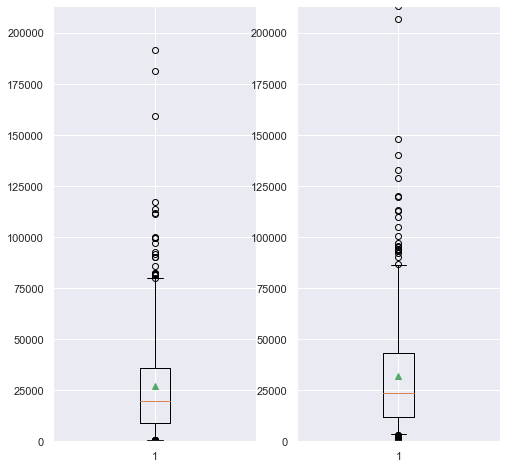

In [563]:

fig, ax1 = plt.subplots(1,2,figsize=(8, 8))
ax1[0].boxplot(data_before['before Revenue'], whis = (5,95), showmeans = True)
ax1[0].set_ylim([0,np.max(data_action['Revenue'])])
ax1[1].boxplot(data_action['Revenue'], whis = (5,95), showmeans = True)
ax1[1].set_ylim([0,np.max(data_action['Revenue'])])

Далее проведем оценку значимости изменений исходя из следующих гипотез: предположим, что выручка при проведении акции осталась неизменной по сравнению с выручкой до проведения акции. Это гипотеза ${H_0}$. Тогда в случае если наша t-статистика Стьюдента будет меньше чем значения статистической значимости, мы можем отвергать данную гипотезу. В данном ноутбуке решена задача одностороннего теста.

In [564]:
def stand_error(a, b):
    std1 = a.std(ddof = 0)
    std2 = b.std(ddof = 0)
    x = std1 ** 2 / a.count()
    y = std2 ** 2 / b.count()
    return np.sqrt(x + y)

def t_st(a, b):
    return (a.mean() - b.mean()) / stand_error(a, b)

def t_test(a, b):
    dof = len(a) + len(b) - 2
    return st.t.sf([abs(t_st(a, b))], dof)

In [565]:
pval_calculated = []
for k in range(len(data_action.columns)):
    tmp = t_test(data_action.iloc[:,k],data_before.iloc[:,k])
    pval_calculated.append(tmp)

In [566]:
list(zip(pval_calculated,data_action.columns))

[(array([0.5]), 'magazin'),
 (array([0.00345821]), 'days'),
 (array([0.00425552]), 'Revenue'),
 (array([0.0003678]), 'Checks'),
 (array([1.42426767e-05]), 'Qty'),
 (array([8.41078686e-14]), 'Avg Check Size'),
 (array([0.20856395]), 'Avg Check')]

Как видно из полученных значений, большая часть изменений является статистически значимыми. Для удобства восприятия информации,
нарисуем эти графики с порогом равным значению статистической значимости.

(-0.5, 6.5)

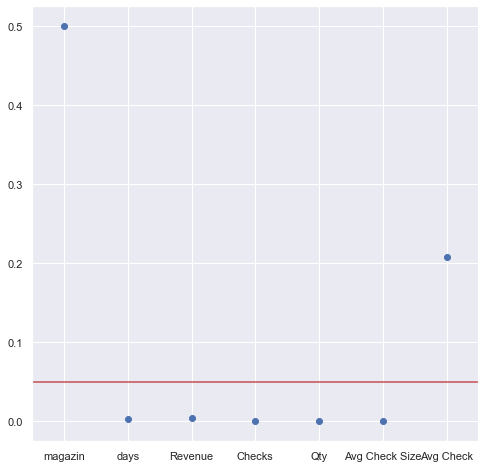

In [567]:
pval_calculated = np.asarray(pval_calculated)
plt.figure(figsize=(8, 8))
plt.scatter(data_action.columns,pval_calculated)
plt.plot([-10,10],[0.05,0.05], color = 'r')
plt.xlim(-0.5,6.5)

Оценим влияние каждого признака на целевую переменную. Для этого требуется разделить целевую переменную от остальных признаков.

In [568]:
target = data_action['Revenue']
data_action.drop('Revenue', axis = 1, inplace = True)
X = data_action

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [569]:
model = ExtraTreesClassifier()
model.fit(X,target)
print(model.feature_importances_)

[0.20259401 0.06767289 0.19554378 0.19895901 0.13487424 0.20035606]


<BarContainer object of 6 artists>

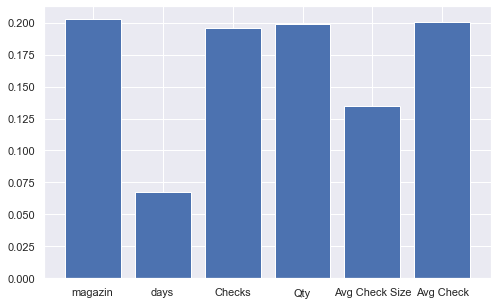

In [570]:
plt.bar(data_action.columns,model.feature_importances_)

Выше представлен анализ влияния признаков на целевую переменную. Полученные результаты хорошо объясняются, так как такие признаки как количество продаж, средний чек, и размер чека и должны описывать выручку магазина. Отдельного внимания заслуживает признак, описывающий номер магазина. Очевидно, что местоположение магазина также влияет на выручку. Однако решение о приянтии проведения акции в том или ином магазине требует более детального изучения данных.